In [1]:
using Pkg
using Plots

Pkg.DEFAULT_IO[] = stdout
Pkg.activate("..")
include("../Grid/Unstaggered.jl")

  Activating environment at `~/Desktop/PhD/Codes/julia_package/ToyModel.jl/Project.toml`


Grid

In [2]:
g = 9.81

Lx = 6
nx = 100
grid = Grid(nx, -Lx/2, Lx/2)

Grid(100, 0.06, 6.0, [-3.0, -2.9393939393939394, -2.878787878787879, -2.8181818181818183, -2.757575757575758, -2.6969696969696972, -2.6363636363636367, -2.575757575757576, -2.5151515151515156, -2.454545454545454  …  2.454545454545454, 2.5151515151515156, 2.575757575757576, 2.6363636363636367, 2.6969696969696972, 2.757575757575758, 2.8181818181818183, 2.878787878787879, 2.9393939393939394, 3.0])

In [16]:
function ∂x_cd!(dfdx, f, grid)
    nx, dx = grid.nx, grid.dx
    dfdx[1] = 1/(2*dx) * (f[2] - f[nx])
    dfdx[nx] = 1/(2*dx) * (f[1] - f[nx-1])
    for i in 2:nx-1
        dfdx[i] = 1/(2*dx) * (f[i+1] - f[i-1])
    end
end

function ∂x_bd!(dfdx, f, grid)
    nx, dx = grid.nx, grid.dx
    dfdx[1] = 1/(dx) * (f[1] - f[nx])
    for i in 2:nx
        dfdx[i] = 1/(dx) * (f[i] - f[i-1])
    end
end

function ∂x_fd!(dfdx, f, grid)
    nx, dx = grid.nx, grid.dx
    dfdx[nx] = 1/(dx) * (f[1] - f[nx])
    for i in 1:nx-1
        dfdx[i] = 1/(dx) * (f[i+1] - f[i])
    end
end

function adv_x_Euler!(adv, dfdx, f, a, grid)
    ∂x_bd!(dfdx, f, grid)
    @. adv = (a + abs(a)) * 0.5 * dfdx
    ∂x_fd!(dfdx, f, grid)
    @. adv = adv + (a - abs(a)) * 0.5 * dfdx
end

adv_x_Euler! (generic function with 1 method)

In [20]:
#Initialising variables
x = grid.x
dx = grid.dx

#Tracer and momentum variables
h_old = zeros(nx)
@. h_old = 1 + 0.05*exp(-5*x^2)
h_new = zeros(nx)
u_old = zeros(nx)
u_new = zeros(nx)

#Equation variables, modified several times at every time step
adv = zeros(nx)
dfdx = zeros(nx)
h_diff = zeros(nx)
u_diff = zeros(nx)

#Time variables
t_start = 0
t_end = 1.2
dt = 0.01

#Needed for making animations
n_steps = Int(t_end/dt)
h_data = zeros(nx, n_steps+1)

#Advecting the variable for fixed number of time steps

count = 1

for t in t_start:dt:t_end
    adv_x_Euler!(adv, dfdx, u_old, u_old, grid)
    ∂x_cd!(h_diff, h_old, grid)
    ∂x_cd!(u_diff, u_old, grid)
    
    @. u_new = u_old - dt*adv - dt*g*h_diff
    @. h_new = h_old - dt*u_old*h_diff - dt*h_old*u_diff
    
    u_old = u_new
    h_old = h_new
    h_data[:, count] = h_old
    count = count+1
end

┌ Info: Saved animation to 
│   fn = /Users/dhruvbhagtani/Desktop/PhD/Codes/julia_package/ToyModel.jl/1D_SWE/ShallowWater.gif
└ @ Plots /Users/dhruvbhagtani/.julia/packages/Plots/XCJgc/src/animation.jl:104


Plots.AnimatedGif("/Users/dhruvbhagtani/Desktop/PhD/Codes/julia_package/ToyModel.jl/1D_SWE/ShallowWater.gif")
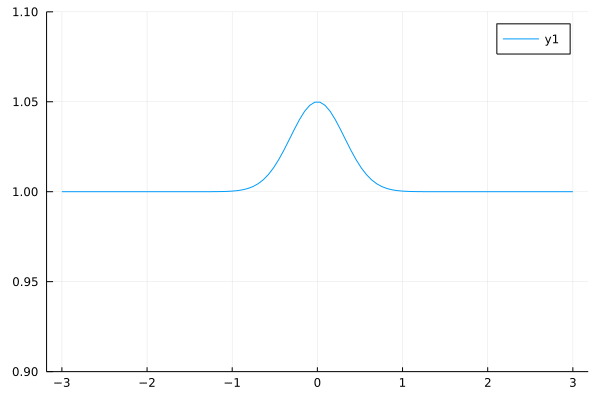

In [21]:
anim = @animate for i = 1:n_steps
    plot(x, h_data[:, i])
    plot!(ylims = (1 - 0.1, 1 + 0.1))
end
 
gif(anim, "ShallowWater.gif", fps = 8)

In [28]:
using BenchmarkTools
@btime ∂x_cd!(h_diff, h_old, grid);

  93.462 ns (0 allocations: 0 bytes)
